# Supervised Post-OCR Correction with Neural Machine Translation

## Import

In [ ]:
from pathlib import Path

## For Colab
is_collab = "google.colab" in str(get_ipython())

if is_collab:
    !rm -rf sample_data
    !mkdir -p data
    !mkdir -p NMT_data/training_data
    !mkdir -p NMT_data/model_data

    from google.colab import drive

    drive.mount("/content/drive")

    !pip install evaluate jiwer OpenNMT-py cer pybind11 transformers[sentencepiece] datasets

    DRIVE = Path("drive/MyDrive/Colab Notebooks/RDI")
    !cp "{DRIVE}/31-all_entries_ner_align_pero.json" data
    !cp "{DRIVE}/10-all_entries_ocr_ner_human.json" data
    !cp "{DRIVE}/naive_nmt_config.yaml" .
    !cp "{DRIVE}/detector_naive_nmt_config.yaml" .
    !cp "{DRIVE}/ne_append_nmt_config.yaml" .

    !git clone  https://github.com/soduco/paper-ner-bench-das22.git
    !cd paper-ner-bench-das22/src/ocr/ ; python setup.py build_ext --inplace

    import sys

    sys.path.append("paper-ner-bench-das22/src/ocr")

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.6/219.6 KB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.4/222.4 KB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 112.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 75.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 96.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 36.9 MB/s et

In [ ]:
import difflib
import re
from xml.dom.minidom import parseString

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from evaluate import load  # Hugging Face
from isri_tools import compute_accurary_summary
from sklearn.model_selection import train_test_split
from text_utils import add_tags_prediction, xml_unescape
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from transformers import (
    CamembertForSequenceClassification,
    CamembertTokenizer,
    Trainer,
    TrainingArguments,
)

SEED = 0

## Data

In [ ]:
if is_collab:
    extracted_data = Path("data/31-all_entries_ner_align_pero.json")
    human_annot_path = Path("data/10-all_entries_ocr_ner_human.json")
else:
    # Modify me
    extracted_data = Path(
        "/home/whojo/Documents/EPITA/LRDE/soduco/data/corrected_data/labeled/original/31-all_entries_ner_align_pero.json"
    )
    human_annot_path = Path(
        "/home/whojo/Documents/EPITA/LRDE/soduco/data/corrected_data/labeled/restructured/10-all_entries_ocr_ner_human.json"
    )

In [ ]:
def json_file_to_df(path: str) -> pd.DataFrame:
    with open(path, "r") as json_file:
        return pd.read_json(json_file)


human_df = json_file_to_df(human_annot_path)
auto_df = json_file_to_df(extracted_data)

len(human_df), len(auto_df)

(8765, 8765)

In [ ]:
df = human_df.loc[:, ["book", "page", "text_ocr", "ner_xml"]]
df = df.rename(columns={"text_ocr": "Ground Truth", "ner_xml": "NER Ground Truth"})
df.loc[:, "Sample"] = auto_df.loc[:, "text_ocr"]
df.loc[:, "NER Sample"] = auto_df.loc[:, "ner_xml"]
df.loc[:, "has_valid_ner_xml"] = auto_df.loc[:, "has_valid_ner_xml"]
df.loc[:, "NER Ground Truth"] = df["NER Ground Truth"].apply(xml_unescape)
df

book  page  \
0                      Bottin1_1820   107   
1                      Bottin1_1820   107   
2                      Bottin1_1820   107   
3                      Bottin1_1820   107   
4                      Bottin1_1820   107   
...                             ...   ...   
8760  Notables_communaux_seine_1801   144   
8761  Notables_communaux_seine_1801   144   
8762  Notables_communaux_seine_1801   144   
8763  Notables_communaux_seine_1801   144   
8764  Notables_communaux_seine_1801   144   

                                           Ground Truth  \
0     Dufan et Clémendot, pharmaciens, r. de la\nCha...   
1     Dufant (Victor), libraire, r. du Gros-Che-\nne...   
2     Dufay, essayeur du commerce, place Dau-\nphine...   
3     Dulay, chandronnier, r. du Pont- aux\nChoux, 1...   
4     Dufay (V.e), grenetière, r. du Faub.-S.\nDenis...   
...                                                 ...   
8760                 Lamarche, géographe , rue du foin.   
8761  Lamarck, membre de l'institut, quatrième munic...   
8762           Lamare, notaire, rue du faubourg honoré.   
8763                 Lamarre , carrier, rue mouffetard.   
8764            Lamarre, clerc de notaire, rue égalité.   

                                       NER Ground Truth  \
0     <PER>Dufan et Clémendot</PER>, <ACT>pharmacien...   
1     <PER>Dufant (Victor)</PER>, <ACT>libraire</ACT...   
2     <PER>Dufay</PER>, <ACT>essayeur du commerce</A...   
3     <PER>Dulay</PER>, <ACT>chandronnier</ACT>, <LO...   
4     <PER>Dufay (V.e)</PER>, <ACT>grenetière</ACT>,...   
...                                                 ...   
8760  <PER>Lamarche</PER>, <ACT>géographe</ACT> , <L...   
8761  <PER>Lamarck</PER>, <ACT>membre de l'institut<...   
8762  <PER>Lamare</PER>, <ACT>notaire</ACT>, <LOC>ru...   
8763  <PER>Lamarre</PER> , <ACT>carrier</ACT>, <LOC>...   
8764  <PER>Lamarre</PER>, <ACT>clerc de notaire</ACT...   

                                                 Sample  \
0     Dufau et Clémendot, pharmaciens, r. de la\nChä...   
1     ☞\n\nT\nDufant (Victor), libraire, r. du Gros-...   
2     Dutay, essayeur du commerce, place Dau-\n\n-\n...   
3     Dulay, chandronnier, r. du Pont- aux-\nChuux, ...   
4     Dufay (V.e), grenetière, r. du Fauh.-S.\nDenis...   
...                                                 ...   
8760                 Lamarche, geographe , rue du foin.   
8761  Lamarck, membre de l'institut, quatrieme munic...   
8762          Lamare , notaire, rue du faubourg honore.   
8763                  Lamarre, carrier, rue mouffetard.   
8764            Lamarre, clerc de notaire, rue égalité.   

                                             NER Sample  has_valid_ner_xml  
0     <PER>Dufau et Clémendot</PER>, <ACT>pharmacien...              False  
1     ☞

T
<PER>Dufant (Victor)</PER>, <ACT>libraire...               True  
2     <PER>Dutay</PER>, <ACT>essayeur du commerce</A...               True  
3     <PER>Dulay</PER>, <ACT>chandronnier</ACT>, <LO...               True  
4     <PER>Dufay (V.e)</PER>, <ACT>grenetière</ACT>,...               True  
...                                                 ...                ...  
8760  <PER>Lamarche</PER>, <ACT>geographe</ACT> , <L...               True  
8761  <PER>Lamarck</PER>, <ACT>membre de l&apos;inst...               True  
8762  <PER>Lamare</PER> , <ACT>notaire</ACT>, <LOC>r...               True  
8763  <PER>Lamarre</PER>, <ACT>carrier</ACT>, <LOC>r...               True  
8764  <PER>Lamarre</PER>, <ACT>clerc de notaire</ACT...               True  

[8765 rows x 7 columns]

### Metrics

In [ ]:
def _align_pred_on_ner(pred_df: pd.DataFrame, gt_df: pd.DataFrame) -> pd.Series:
    """
    Produces pd.Series that contain for each prediction its alignment on NE.
    """

    def align_sample_on_ner_closure():
        def inner_align_sample_on_ner(sample: str) -> str:
            aligned_sample = add_tags_prediction(
                gt_df.loc[inner_align_sample_on_ner.i, "NER Ground Truth"], sample
            )
            inner_align_sample_on_ner.i += 1
            return xml_unescape(aligned_sample)

        inner_align_sample_on_ner.i = 0
        return inner_align_sample_on_ner

    return pred_df["Pred"].apply(align_sample_on_ner_closure())


fake_pred = df[["Sample"]].rename(columns={"Sample": "Pred"})
ner_pred = _align_pred_on_ner(fake_pred, df)
# df["NER Sample"].equals(ner_pred) # Test: should print "True"
fake_pred["NER Sample"] = df["NER Sample"]
fake_pred["NER Ground Truth"] = df["NER Ground Truth"]
fake_pred

Suspect char@060: † (0x2020 DAGGER -- cat.: Po)
Suspect char@028: † (0x2020 DAGGER -- cat.: Po)
Suspect char@011: † (0x2020 DAGGER -- cat.: Po)
Suspect char@007: † (0x2020 DAGGER -- cat.: Po)
Suspect char@011: € (0x20ac EURO SIGN -- cat.: Sc)
Suspect char@008: † (0x2020 DAGGER -- cat.: Po)
Suspect char@011: † (0x2020 DAGGER -- cat.: Po)


Pred  \
0     Dufau et Clémendot, pharmaciens, r. de la\nChä...   
1     ☞\n\nT\nDufant (Victor), libraire, r. du Gros-...   
2     Dutay, essayeur du commerce, place Dau-\n\n-\n...   
3     Dulay, chandronnier, r. du Pont- aux-\nChuux, ...   
4     Dufay (V.e), grenetière, r. du Fauh.-S.\nDenis...   
...                                                 ...   
8760                 Lamarche, geographe , rue du foin.   
8761  Lamarck, membre de l'institut, quatrieme munic...   
8762          Lamare , notaire, rue du faubourg honore.   
8763                  Lamarre, carrier, rue mouffetard.   
8764            Lamarre, clerc de notaire, rue égalité.   

                                             NER Sample  \
0     <PER>Dufau et Clémendot</PER>, <ACT>pharmacien...   
1     ☞

T
<PER>Dufant (Victor)</PER>, <ACT>libraire...   
2     <PER>Dutay</PER>, <ACT>essayeur du commerce</A...   
3     <PER>Dulay</PER>, <ACT>chandronnier</ACT>, <LO...   
4     <PER>Dufay (V.e)</PER>, <ACT>grenetière</ACT>,...   
...                                                 ...   
8760  <PER>Lamarche</PER>, <ACT>geographe</ACT> , <L...   
8761  <PER>Lamarck</PER>, <ACT>membre de l&apos;inst...   
8762  <PER>Lamare</PER> , <ACT>notaire</ACT>, <LOC>r...   
8763  <PER>Lamarre</PER>, <ACT>carrier</ACT>, <LOC>r...   
8764  <PER>Lamarre</PER>, <ACT>clerc de notaire</ACT...   

                                       NER Ground Truth  
0     <PER>Dufan et Clémendot</PER>, <ACT>pharmacien...  
1     <PER>Dufant (Victor)</PER>, <ACT>libraire</ACT...  
2     <PER>Dufay</PER>, <ACT>essayeur du commerce</A...  
3     <PER>Dulay</PER>, <ACT>chandronnier</ACT>, <LO...  
4     <PER>Dufay (V.e)</PER>, <ACT>grenetière</ACT>,...  
...                                                 ...  
8760  <PER>Lamarche</PER>, <ACT>géographe</ACT> , <L...  
8761  <PER>Lamarck</PER>, <ACT>membre de l'institut<...  
8762  <PER>Lamare</PER>, <ACT>notaire</ACT>, <LOC>ru...  
8763  <PER>Lamarre</PER> , <ACT>carrier</ACT>, <LOC>...  
8764  <PER>Lamarre</PER>, <ACT>clerc de notaire</ACT...  

[8765 rows x 3 columns]

In [ ]:
def clean_xml(xml: str) -> str:
    """
    Remove content outside of balises and add "<start>" balises.
    After this processing, the xml is now parsable.

    e.g.:
        input: "adfsf <PER>Dufau et Clémendot</PER>, <ACT>pharmaciens</ACT>, fdasf"
        output: "<start><PER>Dufau et Clémendot</PER><ACT>pharmaciens</ACT></start>"
    """
    xml = xml.replace(
        "<CARDINAL>&", "&<CARDINAL>"
    )  # Quick Fix to remove error on a corner case

    xml = re.sub(">[^<]*<([^/])", r"><\1", xml)  # Remove between balise
    xml = re.sub("^[^<]*", "", xml)  # Remove before first balise
    xml = re.sub("[^>]*$", "", xml)  # Remove after last balise
    return "<start>" + xml + "</start>"


def get_tag_content(document, tag) -> str:
    """
    Extract the content inside a `tag` of the `document`.

    e.g.:
        document = parseString("<PER>Dufau et Clémendot</PER>")
        get_tag_text(document, "PER") # "Dufau et Clémendot"

    Notes:
        Raise an error if the `tag` is not found.
    """
    elts = document.getElementsByTagName(tag)
    if elts == [] or elts[0].firstChild is None:
        return "#"  # XXX: quick and dirty

    return elts[0].firstChild.data


TAGS = ["PER", "ACT", "LOC", "CARDINAL"]


def _compute_metric(
    metric_name: str, pred: pd.DataFrame, ref: pd.DataFrame, tags: list = TAGS
) -> list:
    """
    Compute a specific metric `metric_name` globally and for each tag in `tags`.
    """
    metric = load(metric_name)

    metric_list = [
        metric.compute(predictions=pred["Pred"], references=ref["Ground Truth"])
    ]

    pred_documents_df = pred["NER Pred"].apply(lambda xml: parseString(clean_xml(xml)))
    documents_df = ref["NER Ground Truth"].apply(
        lambda xml: parseString(clean_xml(xml))
    )

    for tag in tags:
        tag_pred = pred_documents_df.apply(lambda doc: get_tag_content(doc, tag))
        tag_gt = documents_df.apply(lambda doc: get_tag_content(doc, tag))

        metric_list.append(metric.compute(predictions=tag_pred, references=tag_gt))

    return metric_list


def compute_all_metrics(
    pred: pd.DataFrame, ref: pd.DataFrame, tags: list = TAGS
) -> pd.DataFrame:
    """
    Compute "CER" and "WER" globally and for each tag in `tags`.
    """
    index_list = ["Global"] + tags
    if "NER Pred" not in pred.columns:
        pred = pred.copy()
        pred["NER Pred"] = _align_pred_on_ner(pred, ref)

    cer_list = _compute_metric("cer", pred, ref, tags=tags)
    cer_macro_list = _compute_metric("character", pred, ref, tags=tags)
    wer_list = _compute_metric("wer", pred, ref, tags=tags)

    cer_macro_list = [score["cer_score"] for score in cer_macro_list]
    return pd.DataFrame(
        {"CER (micro)": cer_list, "CER (macro)": cer_macro_list, "WER": wer_list},
        index=index_list,
    )


def save_to_all_methods(
    new_method_metrics_df: pd.DataFrame,
    methods_metrics_dict: dict = None,
    method_name: str = "Baseline",
) -> (dict, pd.DataFrame):
    """
    Add `new_method_metrics_df` to a copy of the dictory of metrics associated to
    each method, `methods_metrics_dict`. Also computes the clean dataframe containing all the results.
    """
    if methods_metrics_dict is None:
        res_all_metrics_dict = {}
    else:
        res_all_metrics_dict = methods_metrics_dict.copy()

    res_all_metrics_dict[method_name] = new_method_metrics_df
    res_df = pd.concat(res_all_metrics_dict, axis=1)

    return res_all_metrics_dict, res_df


identity_pred_df = df.loc[:, ["Sample", "NER Sample"]]
identity_pred_df = identity_pred_df.rename(
    columns={"Sample": "Pred", "NER Sample": "NER Pred"}
)

identity_metrics_df = compute_all_metrics(identity_pred_df, df)
all_methods_dict, res_df = save_to_all_methods(identity_metrics_df)
res_df

Baseline                      
         CER (micro) CER (macro)       WER
Global      0.037602    0.041686  0.189577
PER         0.028410    0.025330  0.141672
ACT         0.025241    0.015491  0.129234
LOC         0.034666    0.024216  0.173568
CARDINAL    0.072345    0.076861  0.095870

### Data prep

In [ ]:
train_df, test_df = train_test_split(
    df.loc[df["has_valid_ner_xml"], :], test_size=0.1, shuffle=True, random_state=SEED
)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
train_df.shape, test_df.shape, df.loc[df["has_valid_ner_xml"], :].shape, df.shape

((7552, 7), (840, 7), (8392, 7), (8765, 7))

In [ ]:
# IF UPDATING THESE PATHS, ALSO CHANGE THEM IN "NMT_data/nmt_config.yaml"
ONMT_DATA = Path("NMT_data/training_data/")
ONMT_TRAIN_SOURCE = ONMT_DATA / "train.src"
ONMT_TRAIN_TARGET = ONMT_DATA / "train.tgt"
ONMT_TEST_SOURCE = ONMT_DATA / "test.src"
ONMT_TEST_TARGET = ONMT_DATA / "test.tgt"
ONMT_TEST_PRED = ONMT_DATA / "test.pred"


def save_df_on_disk(df: pd.DataFrame, path: Path) -> None:
    """
    Convert the dataframe `df` or serie to the openNMT format and
    saves it on disk at the desired `path`.

    The following transformation are performed in order to fit the
    openNMT format:
    - All characters are separated by spaces in order to perform
    translation at character-level.
    - All real whitespace characters are represented by underscore ("_")
    on disk.
    - Each sample from the dataframe is represented on a single line.
    """
    pd.set_option("display.max_colwidth", None)

    raw_str_df = df.to_string(header=False, index=False)
    no_padding = re.sub("^ *", "", raw_str_df, flags=re.MULTILINE)
    no_white_space_str = no_padding.replace(" ", "_")
    char_split_str = " ".join(no_white_space_str)

    with open(path, "w") as f:
        f.write(char_split_str)


def load_from_disk(
    path: Path, template_df: pd.DataFrame = None, column_name: [str] = ["Pred"]
) -> pd.DataFrame:
    """
    Inverse transformation of `save_df_on_disk`.

    Use `template_df` to set index and colunm name.
    Do not set them, if `template_df` is None.
    """
    with open(path, "r") as f:
        raw_data = f.readlines()

    no_useless_newline = map(lambda line: line.rstrip("\n"), raw_data)
    no_char_split = map(lambda line: line.replace(" ", ""), no_useless_newline)
    whitespace = map(lambda line: line.replace("_", " "), no_char_split)
    normalised = map(lambda line: line.replace("\\n", "\n"), whitespace)

    if template_df is None:
        return pd.DataFrame(normalised)

    return pd.DataFrame(normalised, index=template_df.index, columns=column_name)


save_df_on_disk(train_df["Sample"], ONMT_TRAIN_SOURCE)
new_train_df = load_from_disk(ONMT_TRAIN_SOURCE, train_df[["Sample"]], ["Sample"])
new_train_df.equals(train_df[["Sample"]])  # Test: should print "True"

True

In [ ]:
# Save data to OpenNMT format
save_df_on_disk(train_df["Sample"], ONMT_TRAIN_SOURCE)
save_df_on_disk(train_df["Ground Truth"], ONMT_TRAIN_TARGET)

save_df_on_disk(test_df["Sample"], ONMT_TEST_SOURCE)
save_df_on_disk(test_df["Ground Truth"], ONMT_TEST_TARGET)

In [ ]:
# Build vocabulary
NAIVE_CONFIG_PATH = "naive_nmt_config.yaml"

def build_vocab(config_path: str = NAIVE_CONFIG_PATH) -> None:
    ! onmt_build_vocab -config $config_path -n_sample 10000

build_vocab()

Corpus train's weight should be given. We default it to 1 for you.
[2023-02-17 07:47:01,888 INFO] Counter vocab from 10000 samples.
[2023-02-17 07:47:01,888 INFO] Build vocab on 10000 transformed examples/corpus.
[2023-02-17 07:47:02,018 INFO] Counters src:129
[2023-02-17 07:47:02,019 INFO] Counters tgt:111


## Post-OCR Correction

### Naive supervised approach

In [ ]:
if is_collab:
    NAIVE_MODEL_PATH = DRIVE / "Saved Models/naive_model_step_2000.pt"
else:
    NAIVE_MODEL_PATH = Path("NMT_data/model_data/naive_model_step_2000.pt")


def train(
    config: str = NAIVE_CONFIG_PATH,
    model: str = NAIVE_MODEL_PATH,
    force_training: bool = False,
) -> None:
    """
    Train the model.

    Note:
        - The training configuration is specified in the `config` yaml file.
        - This function suppose the training and testing files have been saved in
        in the global variables "ONMT_*"
    """
    if model.exists() and not force_training:
        print("Skipped Training")
        return


    ! onmt_train -config $config --num_workers 0 --verbose


train()

Skipped Training


In [ ]:
def test(
    model: str = NAIVE_MODEL_PATH,
    sample_path: str = ONMT_TEST_SOURCE,
    pred_path: str = ONMT_TEST_PRED,
):
    """
    Run the inference of the model, and save its results in `pred_path`.

    Note:
        - This function suppose the training and testing files have been saved in
        in the global variables "ONMT_*"
    """


    ! onmt_translate -model "$model" -src $sample_path -output $pred_path -gpu 0 -verbose

test()

[2023-02-17 07:47:15,643 INFO] 
SENT 1: ['M', 'e', 'q', 'u', 'i', 'g', 'n', 'o', 'n', ',', '_', 'n', 'o', 'u', 'w', '.', '_', 'S', 't', '_', 'S', 'e', 'v', 'e', 'r', 'i', 'n', ',', '_', '1', '1', '.']
PRED 1: M e q u i g n o n , _ n o u v . _ S t _ S è v e r i n , _ 1 1 .
PRED SCORE: -0.0211

[2023-02-17 07:47:15,643 INFO] 
SENT 2: ['P', 'E', 'R', 'R', 'I', 'E', 'R', ',', '_', 'r', '.', '_', 'd', 'e', '_', 'l', 'a', '_', 'G', 'r', 'a', 'n', 'd', 'e', '-', 'T', 'r', 'u', 'a', 'n', 'd', 'e', 'r', 'i', 'e', '_', ',', '_', '5', '0', '.', '\\', 'n', 'F', 'a', 'b', '.', '_', 'o', 'b', 'j', 'e', 't', 's', '_', 'd', 'e', '_', 'f', 'a', 'n', 't', 'a', 'i', 's', 'i', 'e', '.']
PRED 2: P E R R I E R , _ r . _ d e _ l a _ G r a n d e - T r u a n d e r i e _ , _ 5 0 . \ n F a b . _ o b j e t s _ d e _ f a n t a i s i e .
PRED SCORE: -0.0245

[2023-02-17 07:47:15,643 INFO] 
SENT 3: ['G', 'r', 'a', 'n', 'd', 'p', 'r', 'è', 's', '_', '(', 'V', 'v', 'e', '\\', 'n', 't', 'a', 'i', 'l', 'l', 'e', 'u', 'r

In [ ]:
naive_pred_df = load_from_disk(ONMT_TEST_PRED, test_df["Ground Truth"])

naive_metrics_df = compute_all_metrics(naive_pred_df, test_df)
naive_all_method_dict, res_df = save_to_all_methods(
    naive_metrics_df, all_methods_dict, "Naive"
)
res_df

Baseline                             Naive                      
         CER (micro) CER (macro)       WER CER (micro) CER (macro)       WER
Global      0.037602    0.041686  0.189577    0.143068    0.079904  0.291164
PER         0.028410    0.025330  0.141672    0.029575    0.021729  0.113582
ACT         0.025241    0.015491  0.129234    0.152468    0.033095  0.222160
LOC         0.034666    0.024216  0.173568    0.078638    0.059759  0.176845
CARDINAL    0.072345    0.076861  0.095870    0.069902    0.066210  0.088475

### Simple length post-processing regularization

Some predictions seem to append a sequence of token at the end of their prediction. This phenomenon significantly lengthtens those predictions and, therefore, skyrocket their CER (some even above $1$). To prevent this, we can cut the end of the longest chain.

In [ ]:
# %%script false --no-raise-error

test(sample=ONMT_TRAIN_SOURCE)
naive_train_pred_df = load_from_disk(ONMT_TEST_PRED, train_df["Ground Truth"])

Streaming output truncated to the last 5000 lines.
SENT 6553: ['A', 'u', 'd', 'i', 'g', 'a', 'n', 'n', 'e', ',', '_', 'c', 'h', 'e', 'f', '_', 'd', 'e', '_', 'b', 'u', 'r', 'e', 'a', 'u', '_', 'a', 'u', '_', 'm', 'i', 'n', 'i', 's', 't', '.', '_', 'd', 'e', '_', 'l', "'", 'a', '-', '\\', 'n', 'g', 'r', 'i', 'c', 'u', 'l', 't', 'u', 'r', 'e', '_', 'e', 't', '_', 'd', 'u', '_', 'c', 'o', 'm', 'm', 'e', 'r', 'c', 'e', '.']
PRED 6553: A u d i g a n n e , _ c h e f _ d e _ b u r e a u _ a u _ m i n i s t . _ d e _ l ' a - \ n g r i c u l t u r e _ e t _ d u _ c o m m e r c e .
PRED SCORE: -0.0111

[2023-02-17 07:49:02,925 INFO] 
SENT 6554: ['M', 'e', 'r', 'c', 'i', 'e', 'r', ',', '_', 'p', 'i', 'a', 'n', 'o', 's', ',', '_', 'B', 'a', 's', 's', 'e', '_', 'S', 't', '_', 'P', 'i', 'e', 'r', 'r', 'e', '_', 'A', 'm', 'e', 'l', '.', '_', '4', '.']
PRED 6554: M e r c i e r , _ p i a n o s , _ B a s s e _ S t _ P i e r r e _ A m e l . _ 4 .
PRED SCORE: -0.0077

[2023-02-17 07:49:02,925 INFO] 
SENT 

In [ ]:
%%script false --no-raise-error

ratios = np.array([
    len(naive_train_pred_df.loc[i, "Pred"]) / len(train_df.loc[i, "Sample"])
    for i in range(len(naive_train_pred_df))
])

plt.hist(ratios, bins=30)

In [ ]:
def post_process_length_v3(
    pred_df: pd.DataFrame, input_df: pd.DataFrame, *, cut_threshold: float = 1.70
) -> pd.DataFrame:
    ratios = np.array(
        [
            len(pred_df.loc[i, "Pred"]) / len(input_df.loc[i, "Sample"])
            for i in range(len(pred_df))
        ]
    )
    mask = ratios > cut_threshold

    processed_df = pred_df.copy()
    processed_df.loc[mask, "Pred"] = [
        pred[: len(sample)]
        for (pred, sample) in zip(
            processed_df.loc[mask, "Pred"].tolist(), input_df.loc[mask, "Sample"]
        )
    ]

    return processed_df


def post_process_length(
    pred_df: pd.DataFrame, input_df: pd.DataFrame, *, cut_threshold: float = 1.70
) -> pd.DataFrame:
    ratios = np.array(
        [
            len(pred_df.loc[i, "Pred"]) / len(input_df.loc[i, "Sample"])
            for i in range(len(pred_df))
        ]
    )
    mask = ratios > cut_threshold

    processed_df = pred_df.copy()
    processed_df.loc[mask, "Pred"] = input_df.loc[mask, "Sample"]

    return processed_df

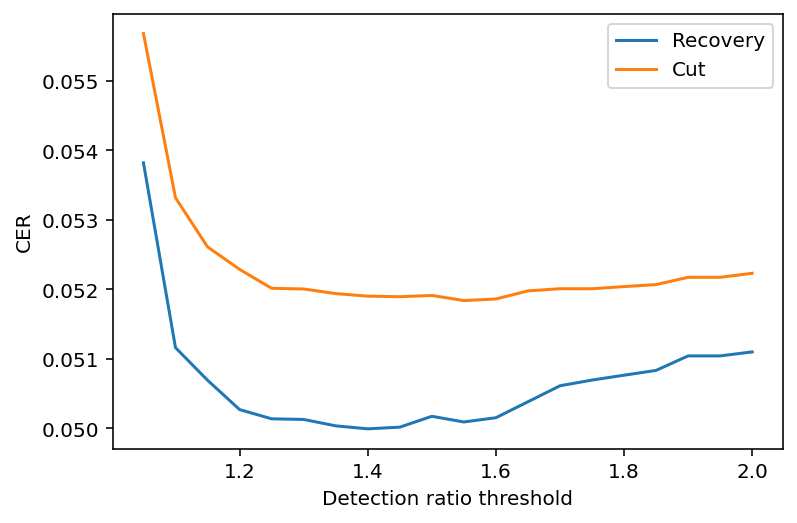

In [ ]:
# %%script false --no-raise-error

# Plot to find optimal cut threshold
cter_list = []
cter_list_v3 = []

cut_range = np.linspace(1.05, 2, 20)
for cut_threshold in cut_range:
    processed_df = post_process_length(
        naive_train_pred_df, train_df, cut_threshold=cut_threshold
    )
    processed_df_v3 = post_process_length_v3(
        naive_train_pred_df, train_df, cut_threshold=cut_threshold
    )
    cter = load("character")

    cter_list.append(
        cter.compute(
            predictions=processed_df["Pred"], references=train_df["Ground Truth"]
        )["cer_score"]
    )

    cter_list_v3.append(
        cter.compute(
            predictions=processed_df_v3["Pred"], references=train_df["Ground Truth"]
        )["cer_score"]
    )

%config InlineBackend.figure_format='retina'
plt.plot(cut_range, cter_list, label="Recovery")
plt.plot(cut_range, cter_list_v3, label="Cut")
plt.ylabel("CER")
plt.xlabel("Detection ratio threshold")
plt.legend()
# plt.title("Evolution of CER for different detection ratio")

In [ ]:
post_processed_v3_naive_pred_df = post_process_length_v3(naive_pred_df, test_df)
compute_all_metrics(post_processed_v3_naive_pred_df, test_df)

CER (micro)  CER (macro)       WER
Global       0.103205     0.073011  0.249869
PER          0.029575     0.021729  0.113582
ACT          0.147468     0.032478  0.217660
LOC          0.068519     0.059331  0.165394
CARDINAL     0.070479     0.066210  0.088475

In [ ]:
%%script false --no-raise-error

# Examples of sentence "hallucination"
naive_train_pred_df.loc[ratios > 6, "Pred"].tolist()

['Petietier, V.-Marché-St-Marché-St-Marché-St-Marché-St-Marché-St-Marché-St-Marché-St-Marché-St-Marché-St-Marché-St-Marché-St-Marché-St-Marché-St-Marché-St-Marché-St-Marché-St-Marché-St-Marché-St-Marché-St-Marché-St-Marché-St-Marché-St-Marché-St-Marché',
 'Dupont , à la Croix Rouge , au coin de la Croix Rouge , au coin de la Croix Rouge , au coin de la Croix Rouge , au coin de la Croix Rouge , au coin de la Croix Rouge , au coin de la Croix Rouge , au coin de la Croix Rouge , au coin de la Croix Rouge ',
 'Corvisy (feab.), R. S. Martin, 329.\nC. R. S. Martin, 329.\nC. R. S. Martin, 329.\nC. R. S. Martin, 329.\nC. R. S. Martin, 329.\nC. R. S. Martin, 329.\nC. R. S. Martin, 329.\nC. R. S. Martin, 329.\nC. R. S. Martin, 329.\nC. R. S. Martin, 329.\nC. R. ',
 'Mille TR. et PEAIFe, r. Glansnvoix. 3. paO. paO. paO. paO. paO. paO. paO. paO. paO. paO. paO. paO. paO. paO. paO. paO. paO. paO. paO. paO. paO. paO. paO. paO. paO. paO. paO. paO. paO. paO. paO. paO. paO. paO. paO. paO. paO. paO. paO.

In [ ]:
train_df.loc[ratios > 6, "Sample"]

3988          Pelletier,\nV.-Marché-St-Martin, 5.
5611    Dupont , à la Croix Rouge , au coin de la
6698       Corvis)\n(Iab.\n), R. S. Martin . 329.
6712       MilRITR, Ie PEAIFe, r. Glansnvo O. paO
6978         Bailleul, O. *, propr., Martyrs, 35.
Name: Sample, dtype: object

In [ ]:
# Now on the test set
post_processed_naive_pred_df = post_process_length(naive_pred_df, test_df)

post_processed_naive_metrics_df = compute_all_metrics(
    post_processed_naive_pred_df, test_df
)
post_processed_naive_all_method_dict, res_df = save_to_all_methods(
    post_processed_naive_metrics_df, naive_all_method_dict, "Naive & len post-process"
)
res_df

Baseline                             Naive                        \
         CER (micro) CER (macro)       WER CER (micro) CER (macro)       WER   
Global      0.037602    0.041686  0.189577    0.143068    0.079904  0.291164   
PER         0.028410    0.025330  0.141672    0.029575    0.021729  0.113582   
ACT         0.025241    0.015491  0.129234    0.152468    0.033095  0.222160   
LOC         0.034666    0.024216  0.173568    0.078638    0.059759  0.176845   
CARDINAL    0.072345    0.076861  0.095870    0.069902    0.066210  0.088475   

         Naive & len post-process                        
                      CER (micro) CER (macro)       WER  
Global                   0.100553    0.071725  0.245144  
PER                      0.029575    0.021729  0.113582  
ACT                      0.146104    0.032174  0.214286  
LOC                      0.064660    0.057235  0.160305  
CARDINAL                 0.067013    0.063234  0.086147

### Supervised with NER factor in tokens (Not concluent)
Each named entity consitutes a different vocabulary. Those different vocabulary may exhibit different a priori probabilities. Therefore, indicating the corresponding named entity of a token might help the translation model.

This idea is implemented by regrouping set of tokens for each Named Entity. More precisely this is performed by appending the NE to the token. e.g. the character-level token "T" inside of patronyme (PER) becomes "TPER".

In [ ]:
def _tokenify_with_NE(sample: str) -> str:
    tag_pattern = re.compile("<(?P<tag_name>\w+)>(?P<content>[^<]*)</\w+>")
    tags = tag_pattern.finditer(sample)

    token_list = []
    cur_i = 0

    for tag in tags:
        if sample[cur_i] != "<":  # Add token outside of tags
            token_list += list(sample[cur_i : tag.start()].replace(" ", "_"))

        tag_content = tag["content"].replace(" ", "_")
        tag_token_list = [
            char + tag["tag_name"]  # Concatenate named entity to each token
            for char in tag_content
        ]

        token_list += tag_token_list
        cur_i = tag.end()

    # Add token outside of tags at the end of the sample
    token_list += list(sample[cur_i:].replace(" ", "_"))

    return " ".join(token_list)


def save_df_on_disk_with_NE(df: pd.DataFrame, path: Path) -> None:
    """
    Convert the dataframe `df` or serie to the openNMT format and
    saves it on disk at the desired `path` with named entities append
    to each char token, where appropriate.

    The following transformation are performed in order to fit the
    openNMT format:
    - All characters are separated by spaces in order to perform
    translation at character-level.
    - All real whitespace characters are represented by underscore ("_")
    on disk.
    - Each sample from the dataframe is represented on a single line.
    - The named entity (NE) (e.g. PER, ACT, ...) is append to each token. The
    vocabularies should therefore be rebuild after a call to
    `save_df_on_disk_with_NE`.
    """
    tokenified_samples = df.apply(_tokenify_with_NE)

    with open(path, "w") as f:
        f.write("\n".join(tokenified_samples))


ex = train_df.loc[0, "NER Sample"]
print(ex)
_tokenify_with_NE(ex)

<PER>Labouriau</PER>, <ACT>fab. chaussures</ACT>, <LOC>Christine</LOC>, <CARDINAL>10</CARDINAL>.


'LPER aPER bPER oPER uPER rPER iPER aPER uPER , _ fACT aACT bACT .ACT _ACT cACT hACT aACT uACT sACT sACT uACT rACT eACT sACT , _ CLOC hLOC rLOC iLOC sLOC tLOC iLOC nLOC eLOC , _ 1CARDINAL 0CARDINAL .'

In [ ]:
# %%script false --no-raise-error

save_df_on_disk_with_NE(train_df["NER Sample"], ONMT_TRAIN_SOURCE)
save_df_on_disk_with_NE(test_df["NER Sample"], ONMT_TEST_SOURCE)

NE_APPEND_CONFIG_PATH = "ne_append_nmt_config.yaml"
build_vocab(NE_APPEND_CONFIG_PATH)

print()
print("Example:")
!head $ONMT_TRAIN_SOURCE

Corpus train's weight should be given. We default it to 1 for you.
[2023-02-15 14:36:12,753 INFO] Counter vocab from 10000 samples.
[2023-02-15 14:36:12,753 INFO] Build vocab on 10000 transformed examples/corpus.
[2023-02-15 14:36:13,553 INFO] Counters src:596
[2023-02-15 14:36:13,553 INFO] Counters tgt:111
[2023-02-15 14:36:13,553 WARNING] path NMT_data/model_data/vocab.src exists, may overwrite...
[2023-02-15 14:36:13,555 WARNING] path NMT_data/model_data/vocab.tgt exists, may overwrite...

Example:
LPER aPER bPER oPER uPER rPER iPER aPER uPER , _ fACT aACT bACT .ACT _ACT cACT hACT aACT uACT sACT sACT uACT rACT eACT sACT , _ CLOC hLOC rLOC iLOC sLOC tLOC iLOC nLOC eLOC , _ 1CARDINAL 0CARDINAL .
DPER iPER sPER tPER rPER iPER bPER uPER éPER _PER (PER EPER uPER gPER .PER ) , _ pACT aACT pACT iACT eACT rACT sACT _ACT eACT nACT _ACT gACT rACT oACT sACT , _ ALOC rLOC bLOC rLOC eLOC -LOC  LOC SLOC eLOC cLOC , _ 3CARDINAL 5CARDINAL .
DPER uPER cPER rPER ePER tPER ePER tPER _PER fPER iPER lPE

In [ ]:
# %%script false --no-raise-error

if is_collab:
    NE_APPEND_MODEL_PATH = DRIVE / "Saved Models/ne_append_model_step_2000.pt"
else:
    NE_APPEND_MODEL_PATH = Path("NMT_data/model_data/ne_append_model_step_2000.pt")

train(config=NE_APPEND_CONFIG_PATH, model=NE_APPEND_MODEL_PATH)
test(model=NE_APPEND_MODEL_PATH)

Skipped Training
[2023-02-15 14:36:23,677 INFO] 
SENT 1: ['MPER', 'ePER', 'qPER', 'uPER', 'iPER', 'gPER', 'nPER', 'oPER', 'nPER', ',', '_', 'nACT', 'oACT', 'uACT', 'wACT', '.ACT', '_', 'SLOC', 'tLOC', '_LOC', 'SLOC', 'eLOC', 'vLOC', 'eLOC', 'rLOC', 'iLOC', 'nLOC', ',', '_', '1CARDINAL', '1CARDINAL', '.']
PRED 1: M e q u i g n o n , _ n o u v . _ S t _ S è v e r i n , _ 1 1 .
PRED SCORE: -0.0134

[2023-02-15 14:36:23,677 INFO] 
SENT 2: ['PPER', 'EPER', 'RPER', 'RPER', 'IPER', 'EPER', 'RPER', ',', '_', 'rLOC', '.LOC', '_LOC', 'dLOC', 'eLOC', '_LOC', 'lLOC', 'aLOC', '_LOC', 'GLOC', 'rLOC', 'aLOC', 'nLOC', 'dLOC', 'eLOC', '-LOC', 'TLOC', 'rLOC', 'uLOC', 'aLOC', 'nLOC', 'dLOC', 'eLOC', 'rLOC', 'iLOC', 'eLOC', '_LOC', ',', '_', '5CARDINAL', '0CARDINAL', '.', 'ACT', 'FACT', 'aACT', 'bACT', '.ACT', '_ACT', 'oACT', 'bACT', 'jACT', 'eACT', 'tACT', 'sACT', '_ACT', 'dACT', 'eACT', '_ACT', 'fACT', 'aACT', 'nACT', 'tACT', 'aACT', 'iACT', 'sACT', 'iACT', 'eACT', '.']
PRED 2: P E R R I E R , _ r . _ d

In [ ]:
# %%script false --no-raise-error

ne_append_pred_df = load_from_disk(ONMT_TEST_PRED, test_df["Ground Truth"])

ne_append_metrics_df = compute_all_metrics(ne_append_pred_df, test_df)
ne_append_all_method_dict, _ = save_to_all_methods(
    ne_append_metrics_df, post_processed_naive_all_method_dict, "NE Append"
)

ne_append_post_processed_pred_df = post_process_length(ne_append_pred_df, test_df)

ne_append_post_processed_metrics_df = compute_all_metrics(
    ne_append_post_processed_pred_df, test_df
)
ne_append_all_method_dict, res_df = save_to_all_methods(
    ne_append_post_processed_metrics_df,
    ne_append_all_method_dict,
    "NE Append & len post-process",
)
res_df

Baseline                             Naive                        \
         CER (micro) CER (macro)       WER CER (micro) CER (macro)       WER   
Global      0.037602    0.041686  0.189577    0.143068    0.079904  0.291164   
PER         0.028410    0.025330  0.141672    0.029575    0.021729  0.113582   
ACT         0.025241    0.015491  0.129234    0.152468    0.033095  0.222160   
LOC         0.034666    0.024216  0.173568    0.078638    0.059759  0.176845   
CARDINAL    0.072345    0.076861  0.095870    0.069902    0.066210  0.088475   

         Naive & len post-process                         NE Append  \
                      CER (micro) CER (macro)       WER CER (micro)   
Global                   0.100553    0.071725  0.245144    0.143829   
PER                      0.029575    0.021729  0.113582    0.055010   
ACT                      0.146104    0.032174  0.214286    0.173107   
LOC                      0.064660    0.057235  0.160305    0.086013   
CARDINAL                 0.067013    0.063234  0.086147    0.057770   

                               NE Append & len post-process              \
         CER (macro)       WER                  CER (micro) CER (macro)   
Global      0.083076  0.293788                     0.099840    0.073254   
PER         0.031701  0.148531                     0.035372    0.029019   
ACT         0.042139  0.237908                     0.166924    0.040760   
LOC         0.057333  0.194656                     0.055827    0.051425   
CARDINAL    0.062103  0.081490                     0.053148    0.056151   

                    
               WER  
Global    0.238320  
PER       0.128674  
ACT       0.227222  
LOC       0.161578  
CARDINAL  0.075669

The results are pretty much the same compared to the naive approach.

Though, this approach might be interesting in the unsupervised setting.

### Naive model with error detection preprocessing
Only train and run inference on sample with errors (thanks to the help of a detection model).

Idea from: Robin et al. 2020

#### Intuition

In [ ]:
similar_sample = test_df["Sample"] == test_df["Ground Truth"]
len(
    naive_pred_df.loc[similar_sample, "Pred"]
    != test_df.loc[similar_sample, "Ground Truth"]
), np.sum(similar_sample), len(naive_pred_df)

(384, 384, 840)

$100$% ($\frac{384}{384} = 1.0$) of error-free samples are wrongly-corrected by the translation model. But those represent $45$% ($\frac{384}{840}\approx 0.45$) of the test set.

In [ ]:
cer = load("cer")
cter = load("character")

cer_score = cer.compute(
    predictions=naive_pred_df.loc[similar_sample, "Pred"].reset_index(drop=True),
    references=test_df.loc[similar_sample, "Ground Truth"].reset_index(drop=True),
)
cter_score = cter.compute(
    predictions=naive_pred_df.loc[similar_sample, "Pred"].reset_index(drop=True),
    references=test_df.loc[similar_sample, "Ground Truth"].reset_index(drop=True),
)

cer_score, cter_score["cer_score"]

(0.11865646449870597, 0.04554201769043166)

Those insights are promising. Indeed a detector model with a 80% precision, would decrease the macro CER by an absolute $0.45 \times 0.045 \times 0.80 = 0.016$ (or equivalently $16$% relative improvement).

#### Implementation of detection model

In [ ]:
model_name = "camembert-base"

tokenizer = CamembertTokenizer.from_pretrained(model_name)
model = CamembertForSequenceClassification.from_pretrained(model_name, num_labels=1)

tokenized_train = [tokenizer(sample) for sample in train_df["Sample"]]
tokenized_test = [tokenizer(sample) for sample in test_df["Sample"]]

train_target = torch.tensor(
    train_df["Sample"] != train_df["Ground Truth"], dtype=torch.float
)
test_target = torch.tensor(
    test_df["Sample"] != test_df["Ground Truth"], dtype=torch.float
)


class DataFrameDataset(Dataset):
    def __init__(self, sample, target):
        self.sample = sample
        self.target = target

    def __len__(self):
        return len(self.sample)

    def __getitem__(self, idx):
        full_sample = self.sample[idx]
        full_sample["labels"] = self.target[idx]
        return full_sample
        return self.sample[idx], self.target[idx]


train_dataset = DataFrameDataset(tokenized_train, train_target)
eval_dataset = DataFrameDataset(tokenized_test, test_target)


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = (predictions > 0.5).astype(float)

    return {
        **load("precision").compute(predictions=predictions, references=labels),
        **load("recall").compute(predictions=predictions, references=labels),
        **load("f1").compute(predictions=predictions, references=labels),
    }


args = TrainingArguments(
    f"{model_name}-finetuned",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="precision",
    per_device_train_batch_size=32,
    num_train_epochs=10,
)

trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

BEST_DETECTOR_PATH = DRIVE / "Saved Models/best_detector"
if not BEST_DETECTOR_PATH.exists():
    trainer.train()
else:
    print("Model's weights found. Skiping training.")

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.out_proj.bias

Model's weights found. Skiping training.


In [ ]:
if not BEST_DETECTOR_PATH.exists():
    !mv $model_name/checkpoint-1180/* "$BEST_DETECTOR_PATH"
    trainer.evaluate()

In [ ]:
detection_tokenizer = CamembertTokenizer.from_pretrained(BEST_DETECTOR_PATH)
detection_model = CamembertForSequenceClassification.from_pretrained(BEST_DETECTOR_PATH)

loading file sentencepiece.bpe.model
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading configuration file drive/MyDrive/Colab Notebooks/RDI/Saved Models/best_detector/config.json
Model config CamembertConfig {
  "_name_or_path": "camembert-base",
  "architectures": [
    "CamembertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 5,
  "classifier_dropout": null,
  "eos_token_id": 6,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "camembert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "regression",
  "torch_dtype": "float32",
  "transfor

#### Retraining ONMT only on samples with error

In [ ]:
dissimilar = train_df["Sample"] != train_df["Ground Truth"]

save_df_on_disk(train_df.loc[dissimilar, ["Sample"]], ONMT_TRAIN_SOURCE)
save_df_on_disk(train_df.loc[dissimilar, ["Ground Truth"]], ONMT_TRAIN_TARGET)

DETECTOR_NAIVE_MODEL_PATH = DRIVE / "Saved Models/detector_naive_model_step_2000.pt"
DETECTOR_NAIVE_CONFIG_PATH = "detector_naive_nmt_config.yaml"

train(DETECTOR_NAIVE_CONFIG_PATH, DETECTOR_NAIVE_MODEL_PATH)

Skipped Training


#### Detection model evaluation


In [ ]:
encoding_list = [
    detection_tokenizer(sample, padding=True, return_tensors="pt")
    for sample in test_df["Sample"]
]
errored_samples_pred = np.array(
    [detection_model(**encoding).logits.item() > 0.5 for encoding in encoding_list]
)

In [ ]:
errored_samples_gt = test_df["Sample"] != test_df["Ground Truth"]

recall, prec, f1 = load("recall"), load("precision"), load("f1")

detection_metric = {
    **recall.compute(predictions=errored_samples_pred, references=errored_samples_gt),
    **prec.compute(predictions=errored_samples_pred, references=errored_samples_gt),
    **f1.compute(predictions=errored_samples_pred, references=errored_samples_gt),
}
pd.DataFrame(detection_metric, index=["Detection model"])

recall  precision        f1
Detection model  0.671053   0.836066  0.744526

In [ ]:
false_negative = np.logical_not(errored_samples_pred) & errored_samples_gt


def get_diff(a: str, b: str):
    return [
        str((i, diff)) for (i, diff) in enumerate(difflib.ndiff(a, b)) if diff[0] != " "
    ]


def get_diff_lines(df: pd.DataFrame) -> pd.DataFrame:
    df["Length"] = df["Sample"].apply(len)
    df["Diff"] = df.apply(
        lambda line: get_diff(line["Sample"], line["Ground Truth"]), axis=1
    )
    df["CER"] = df.apply(
        lambda line: f'{cer.compute(predictions=[line["Sample"]], references=[line["Ground Truth"]]):.3f}',
        axis=1,
    )
    return df


diff_lines = get_diff_lines(test_df.loc[false_negative, ["Sample", "Ground Truth"]])
diff_lines

Sample  \
8                                                                                     Gérardin, tonnellier et march, de bout., Bergère, 27.   
20                                                                      Grandpierre , pasteur de l'Eglise réformée,\nOratoire-du-Louvre, 4.   
26                                                                                          Leprovost père et fils, teintur. , Temple, 197.   
34   Duquenne (Léon) et Cie, draps et\nnouveautés d'Elbeuf, dépôt de\nG. Cunin-Gridaine père et fils de\nSedan, exportation, Jeûneurs,\n46.   
38                                                                                                     Petit (G), relieur, f. du Roule, 15.   
..                                                                                                                                      ...   
819                                                                                              Legrand, beurre et oeufs, Tounellerie, 75.   
825                                                    Aucler (A.), mercerie et quincaill., dépôt\nd'aiguilles, Bourg-l'Abbé, 19 ancien 21.   
829                                                                           Chaumonot-Prince, graveur sur métaux, quai\ndes Orfevres, 66.   
834                                                                                                        Costel, R. de la Feuillade, 455.   
837                                                                            Peinson (fab.), R. du Ponceau, près l'é-\ngoût.— A. de la P.   

                                                                                                                               Ground Truth  \
8                                                                                     Gérardin, tonnellier et march. de bout., Bergère, 27.   
20                                                                       Grandpierre, pasteur de l'Eglise réformée,\nOratoire-du-Louvre, 4.   
26                                                                                           Leprovost père et fils, teintur., Temple, 197.   
34   Duquenne (Léon) et Cie, draps et\nnouveautés d'Elbeuf, dépôt de\nG. Cunin-Gridaine père et fils de\nSedan, exportation, Jeuneurs,\n46.   
38                                                                                                    Petit (C.), relieur, f. du Roule, 15.   
..                                                                                                                                      ...   
819                                                                                              Legrand, beurre et oeufs, Tonnellerie, 15.   
825                                                  Aucler (A.), mercerie et quincaill., dépôt\nd'aiguilles, Bourg-l'Abbé, 19 ancien 21. *   
829                                                                           Chaumonot-Prince, graveur sur métaux, quai\ndes Orfèvres, 66.   
834                                                                                                       Costel, R. de la Feuillade , 455.   
837                                                                           Peinson (fab.), R. du Ponceau, près l'é-\ngoût. — A. de la P.   

     Length                                                  Diff    CER  
8        53                            [(29, '- ,'), (30, '+ .')]  0.019  
20       66                                         [(11, '-  ')]  0.015  
26       47                                         [(32, '-  ')]  0.022  
34      130                          [(119, '- û'), (120, '+ u')]  0.008  
38       36                  [(7, '- G'), (8, '+ C'), (9, '+ .')]  0.054  
..      ...                                                   ...    ...  
819      42  [(28, '- u'), (29, '+ n'), (40, '- 7'), (41, '+ 1')]  0.048  
825      83                            [(83, '+  '), (84, '+ *')]  0.024  
829      60             

In [ ]:
# Is the CER of false negative lower than CER on all data ? (i.e. is the detection model only missing lower-errored samples ?)
cer.compute(
    predictions=diff_lines["Sample"].reset_index(drop=True),
    references=diff_lines["Ground Truth"].reset_index(drop=True),
)  # 0.032 vs 0.037: not that much significant...

0.03223957587046855

In [ ]:
false_positive = errored_samples_pred & np.logical_not(errored_samples_gt)
test_df.loc[false_positive, ["Sample", "Ground Truth"]]

Sample  \
13                                                                                                                      Georget (miniat. gouaches ) rue Feydeau, no. 223.   
22                                                                                                            Cousin, fabr. de quincaillerie, Acacias-de-l'E-\ntoile, 53.   
31                                                                                                                      Hind (Jean), fab., R. Quincampoix, 6—8. Lombards.   
33                                          = DE SECOURS MUTUELS DE FORGERONS\nET CHARRONS DE PARIS, Valois, 8;\nfond. le 1er fev. 1819. Prés., Go-\nbert; secr., Michel.   
35                                                                                                                        Auger, rue de Colbert, n.° 283 , —de Pelletier.   
41                                                                                                  Chevalier, rue des Fossés-Germain, n.° 251 ,—des Gardes-\nFrançaises.   
48                                                                                                                                    Morard fils, boucher, Chaillot. 22.   
90                                                                                                                    Grandhomme, secrét. du Jockey Club, Gram-\nmont, 30   
95                                                                                                                           Doersch, limonadier, Geoffroy-St-Hilaire, 23   
101                                                                                                               Delatourmignière, greff. 1re inst., boul. St-Martin, 4.   
127                                                                                                                                         Boferding, r. St Martin, 171,   
167                                                                                                                                                  Schirodan, Lille, 41   
174                                                                                                                               Vignon, Cte de Servasca, Lamartine, 34.   
231                                                                                                                             Bornat, fab. d'acier p li, Chapon, 6 bis.   
253                                                                                                                            Lamarche , R. Lazare, 117—121. Mont Blanc.   
267                                                                                                                        Preux fils, voit. publiq., r. N.-St.-Denis. 25   
275                                                                                                                                   Guietand, R. du Four , 32.—H. au B.   
277                                                                                                                    Caudron Antheaume, nouveautés, St-Honoré; 290 bis.   
278                                                                                                                       Paque (Jos. ), en laine, Faub.-St-\nDenis, 105.   
338                                                                                                             Aron Javal (L.) art. de Paris, r. des Bour-\ndonnais, 17.   
408                                                                                                                                   Gusman (Mad.), r.des SS.-Pères, 59.   
419                                                                                                                                  Dematharel, R. Pigalle. 39. — M. Bl.   
422                                                                                                                                       Dissard, dessinateur, Sèvres. 2   
443        

In [ ]:
true_positive = errored_samples_pred & errored_samples_gt
test_df.loc[true_positive, ["Sample", "Ground Truth"]]

Sample  \
0                                                   Mequignon, nouw. St Severin, 11.   
2                                        Grandprès (Vve\ntailleur, St-Domnique, 180.   
4    Prevost,  S. Hortic. 1832, ga-\nlerie de Nemours, 13 et 14, Pa-\nlais-National.   
7                                          Mercier, bonnef. St Jacques la Bouch. 52.   
9                                                          Steuer, ében. Morcau, 10.   
..                                                                               ...   
831                                               Scheek (caros.\n"R. du Hélder, 14.   
832                                         Boudrot, R. du Marché aux Poirées , 335.   
835                      Prevost, GS. H 1832, Palais-Royal,\ngal. de Nemours, 13-14.   
836                 Dufort fils, bottier (exp. 1819.), r. J.-J..\nRousscan. 18.\n290   
839                                       Chautard, bonnetier, Nve-des-P.-Champs. 30   

                                                                         Ground Truth  
0                                                    Mequignon, nouv. St Severin, 11.  
2                                        Grandprès(Vve), tailleur, St-Dominique, 180.  
4    Prévost, Ⓐ S. Hortic. 1832, ga-\nlerie de Nemours, 13 et 14, Pa-\nlais-National.  
7                                           Mercier, bonnet. St Jacques la Bouch. 52.  
9                                                           Steuer, ébén. Moreau, 10.  
..                                                                                ...  
831                                               Scheek (caros.) , R. du Helder, 14.  
832                                         Boudrot , R. du Marché aux Poirées , 335.  
835                      Prevost, ⒶS. H. 1832, Palais-Royal,\ngal. de Nemours, 13-14.  
836                   Dufort fils, bottier (exp. 1819.), r. J.-J.-\nRousseau. 18. 295  
839                                       Chautard, bonnetier, Nve-des-P.-Champs, 30.  

[306 rows x 2 columns]

In [ ]:
# Higher proportion of some special chars ? (= lack of preprocessing to regularize input of detector model ?)
fp_df = test_df.loc[false_positive, "Sample"]


def char_distribution(char):
    return np.mean(fp_df.apply(lambda sample: char in sample)), np.mean(
        test_df.loc[:, "Sample"].apply(lambda sample: char in sample)
    )


char_distribution("\n")

(0.2833333333333333, 0.43333333333333335)

In [ ]:
char_distribution("—")

(0.2, 0.06666666666666667)

In [ ]:
char_distribution("°")

(0.08333333333333333, 0.010714285714285714)

##### Idea: How does it perform on GT ?

In [ ]:
encoding_list = [
    detection_tokenizer(sample, padding=True, return_tensors="pt")
    for sample in test_df["Ground Truth"]
]
errored_samples_pred = np.array(
    [detection_model(**encoding).logits.item() > 0.5 for encoding in encoding_list]
)

In [ ]:
errored_samples_pred.sum()

233

In [ ]:
test_df.loc[errored_samples_pred, ["Ground Truth"]]

Ground Truth
4                  Prévost, Ⓐ S. Hortic. 1832, ga-\nlerie de Nemours, 13 et 14, Pa-\nlais-National.
7                                                         Mercier, bonnet. St Jacques la Bouch. 52.
13                                                Georget (miniat. gouaches ) rue Feydeau, no. 223.
14                            Vasset, O. , ancien référendaire à la cour des\ncomptes, Enfer, 102.
15   Vattone (Edouard), entrepreneur de démoli-\ntions, cour Batave , 8; chantier, Vaugirard,\n151.
..                                                                                              ...
828                                                  Gard Letertre (Mlle.J.),fab.,r. Ste.-Anne, 59.
830                                         Costard [ fab. ], R. de l'Arbre Sec, 192. Gardes Franc.
831                                                             Scheek (caros.) , R. du Helder, 14.
834                                                               Costel, R. de la Feuillade , 455.
836                                 Dufort fils, bottier (exp. 1819.), r. J.-J.-\nRousseau. 18. 295

[233 rows x 1 columns]

#### Evaluation pipeline

In [ ]:
save_df_on_disk(test_df.loc[errored_samples_pred, ["Sample"]], ONMT_TEST_SOURCE)
test()

[2023-01-31 17:18:36,185 INFO] 
SENT 1: ['P', 'r', 'e', 'v', 'o', 's', 't', ',', '_', '_', 'S', '.', '_', 'H', 'o', 'r', 't', 'i', 'c', '.', '_', '1', '8', '3', '2', ',', '_', 'g', 'a', '-', '\\', 'n', 'l', 'e', 'r', 'i', 'e', '_', 'd', 'e', '_', 'N', 'e', 'm', 'o', 'u', 'r', 's', ',', '_', '1', '3', '_', 'e', 't', '_', '1', '4', ',', '_', 'P', 'a', '-', '\\', 'n', 'l', 'a', 'i', 's', '-', 'N', 'a', 't', 'i', 'o', 'n', 'a', 'l', '.']
PRED 1: P r é v o s t . _ S . _ H o r t i c . _ 1 8 3 2 , _ g a - \ n l e r i e _ d e _ N e m o u r s .
PRED SCORE: -0.0347

[2023-01-31 17:18:36,186 INFO] 
SENT 2: ['M', 'e', 'r', 'c', 'i', 'e', 'r', ',', '_', 'b', 'o', 'n', 'n', 'e', 'f', '.', '_', 'S', 't', '_', 'J', 'a', 'c', 'q', 'u', 'e', 's', '_', 'l', 'a', '_', 'B', 'o', 'u', 'c', 'h', '.', '_', '5', '2', '.']
PRED 2: M e r c i e r , _ b o n n e f . _ S t _ J a c q u e s _ l a _ B o u c h . _ 5 2 .
PRED SCORE: -0.0436

[2023-01-31 17:18:36,186 INFO] 
SENT 3: ['G', 'e', 'o', 'r', 'g', 'e', 't', '_',

In [ ]:
detector_naive_errored_pred_df = load_from_disk(
    ONMT_TEST_PRED, test_df.loc[errored_samples_pred, "Ground Truth"]
)
detector_naive_pred_df = pd.concat(
    [
        detector_naive_errored_pred_df,
        test_df.loc[np.invert(errored_samples_pred), ["Sample"]].rename(
            columns={"Sample": "Pred"}
        ),
    ]
).sort_index()

post_processed_detector_naive_pred_df = post_process_length(
    detector_naive_pred_df, test_df
)

detector_naive_metrics_df = compute_all_metrics(detector_naive_pred_df, test_df)
post_processed_detector_naive_metrics_df = compute_all_metrics(
    post_processed_detector_naive_pred_df, test_df
)

detector_naive_all_method_dict, _ = save_to_all_methods(
    detector_naive_metrics_df, post_processed_naive_all_method_dict, "Detector & Naive"
)
post_processed_detector_naive_all_method_dict, res_df = save_to_all_methods(
    post_processed_detector_naive_metrics_df,
    detector_naive_all_method_dict,
    "Detector & Naive & len post-processed",
)
res_df

Baseline                             Naive                        \
         CER (micro) CER (macro)       WER CER (micro) CER (macro)       WER   
Global      0.037602    0.041686  0.189577    0.143068    0.079904  0.291164   
PER         0.028410    0.025330  0.141672    0.029575    0.021729  0.113582   
ACT         0.025241    0.015491  0.129234    0.152468    0.033095  0.222160   
LOC         0.034666    0.024216  0.173568    0.078638    0.059759  0.176845   
CARDINAL    0.072345    0.076861  0.095870    0.069902    0.066210  0.088475   

         Naive & len post-process                       Detector & Naive  \
                      CER (micro) CER (macro)       WER      CER (micro)   
Global                   0.100553    0.071725  0.245144         0.078693   
PER                      0.029575    0.021729  0.113582         0.032060   
ACT                      0.146104    0.032174  0.214286         0.080371   
LOC                      0.064660    0.057235  0.160305         0.046394   
CARDINAL                 0.067013    0.063234  0.086147         0.059503   

                               Detector & Naive & len post-processed  \
         CER (macro)       WER                           CER (micro)   
Global      0.056785  0.226422                              0.070269   
PER         0.022598  0.128674                              0.032060   
ACT         0.021152  0.145107                              0.077098   
LOC         0.042588  0.147583                              0.043393   
CARDINAL    0.058146  0.077998                              0.058925   

                                
         CER (macro)       WER  
Global      0.055181  0.219598  
PER         0.022598  0.128674  
ACT         0.020676  0.140607  
LOC         0.041664  0.143766  
CARDINAL    0.057551  0.077998

#### Error analysis

##### OCR's raw error (before correction)

In [ ]:
compute_accurary_summary(
    test_df["Sample"], test_df["Ground Truth"]
)  # What does the error of the OCR looks like ? (mainly single edits)

UNLV-ISRI OCR Accuracy Report Version 5.1
-----------------------------------------
   40471   Characters
    1263   Errors
   96.88%  Accuracy

       0   Reject Characters
       0   Suspect Markers
       0   False Marks
    0.00%  Characters Marked
   96.88%  Accuracy After Correction

     Ins    Subst      Del   Errors
       0        0        0        0   Marked
     166      680      417     1263   Unmarked
     166      680      417     1263   Total

   Count   Missed   %Right
    5194      224    95.69   ASCII Spacing Characters
    5429      128    97.64   ASCII Special Symbols
    1765       58    96.71   ASCII Digits
    3252      132    95.94   ASCII Uppercase Letters
   24259      244    98.99   ASCII Lowercase Letters
       9        3    66.67   Latin1 Special Symbols
       1        1     0.00   Latin1 Uppercase Letters
     485       22    95.46   Latin1 Lowercase Letters
       8        7    12.50   Latin Extended-A
       2        2     0.00   Cyrillic
      59    

##### Correction model's edit

In [ ]:
compute_accurary_summary(
    test_df["Sample"], post_processed_detector_naive_pred_df["Pred"]
)  # How OCR's errors are corrected by the correction model ?

UNLV-ISRI OCR Accuracy Report Version 5.1
-----------------------------------------
   40471   Characters
    2022   Errors
   95.00%  Accuracy

       0   Reject Characters
       0   Suspect Markers
       0   False Marks
    0.00%  Characters Marked
   95.00%  Accuracy After Correction

     Ins    Subst      Del   Errors
       0        0        0        0   Marked
    1551      238      233     2022   Unmarked
    1551      238      233     2022   Total

   Count   Missed   %Right
    5194      323    93.78   ASCII Spacing Characters
    5429      211    96.11   ASCII Special Symbols
    1765       82    95.35   ASCII Digits
    3252      172    94.71   ASCII Uppercase Letters
   24259      954    96.07   ASCII Lowercase Letters
       9        0   100.00   Latin1 Special Symbols
       1        0   100.00   Latin1 Uppercase Letters
     485       34    92.99   Latin1 Lowercase Letters
       8        2    75.00   Latin Extended-A
       2        1    50.00   Cyrillic
      59    

- First, lot of long sentence seems to be completely erased, as the cell just below illustrates it. The model seems to favor short form address (kind of standardization ?)
- It does correctly include context ('\n' are replaced by different string depending on the context, e.g. "), ", " ", ", " or " (").
- The model rarely performs single-character edits. But it is supposed to be the most common kind of errors (see cell above)...

##### Is the correction model performing standardisation ?

In [ ]:
# Example of sample santardization. The correction model significantly shorten this sample.
error_analysis = test_df.copy()
error_analysis["Pred"] = post_processed_detector_naive_pred_df["Pred"]


def extract_sample_with(part_of_line: str) -> pd.DataFrame:
    return error_analysis.loc[test_df["Sample"].apply(lambda l: part_of_line in l), :]


extract_sample_with("Cultures expérimentales")

book  page  \
140  Didot_1851a   639   

                                                                                                                                                                                                                                                                                                                                                                                                                                  Ground Truth  \
140  Jacquin aîné et Cie, grainiers,\nfleuristes et pépiniéristes ; com-\nmerce en gros et en détail de\ngraines potagères et fourragè-\nres, graines de fleurs et d'ar-\nbres, oignons à fleurs et plantes\net arbres de tous genres ; au Bon\nJardinier, quai de la Mégisse-\nrie, 14. Cultures expérimentales,\nau Grand-Charonne, route de\nBagnolet, 20, près Paris; mé-\ndailles d'or et d'argent des di-\nverses sociétés horticoles. *   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   NER Ground Truth  \
140  <PER>Jacquin aîné et Cie</PER>, <ACT>grainiers,\nfleuristes et pépiniéristes ; com-\nmerce en gros et en détail de\ngraines potagères et fourragè-\nres, graines de fleurs et d'ar-\nbres, oignons à fleurs et plantes\net arbres de tous genres </ACT>; <LOC>au Bon\nJardinier, quai de la Mégisse-\nrie</LOC>, <CARDINAL>14</CARDINAL>. <FT>Cultures expérimentales</FT>,\nau <LOC>Grand-Charonne</LOC>, <LOC>route de\nBagnolet</LOC>, <CARDINAL>20</CARDINAL>, <LOC>près Paris</LOC>; mé-\ndailles d'or et d'argent des di-\nverses sociétés horticoles. *   

                                                                                                                                                                                                                                                                                                                                                                                                                                    Sample  \
140  Jacquin aîné et Cie, gramiers,\nfleuristes et pépiniéristes; com-\nmerce en gros et en détail de\ngraines potagères et fourragè-\nres, graines de fleurs et d'ar-\nbres, oignons à fleurs et plantes\net arbres de tous genres ; au Bon\nJardinier, quai de la Mégisse-\nrie, 14. Cultures expérimentales,\nau Grand-Charonne, route de\nBagnolet, 20, près Paris; mé-\ndailles d'or et d'argent des di-\nverses societés horticoles.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        NER Sample  \
140  <PER>Jacquin aîné et Cie</PER>, <ACT>gramiers,
fleuristes et pépiniéristes; com-
merce en gros et en détail de
graines potagères et fourragè-
res, graines de fleurs et d&apos;ar-
bres, oignons à fleurs et plantes
et arbres de tous genres </ACT>; <LOC>au Bon
Jardinier, quai de la Mégisse-
rie</LOC>, <CARDINAL>14</CARDINAL>. <FT>Cultures expérimentales</FT>,
au <LOC>Grand-Charonne</LOC>, <LOC>route de
Bagnolet</LOC>, <CARDINAL>20</CARDINAL>, <LOC>près Paris</LOC>; mé-
dailles d&apos;or et d&apos;argent des di-
verses societés horticoles.   

     has_valid_ner_xml   

In [ ]:
extract_sample_with("Beaujolois-du-Palais")

book  page  \
645  Bottin1_1820   201   

                                                                                                                                                  Ground Truth  \
645  Millan, fab. de boyaux, fabrique à Eli-\nchy-la-Garenne , au bac d'Asnières ;\ndépôt, r. Beaujolois-du-Palais-Royal, 16.\n(exp. 1819) 304, 327, 401, 301.   

                                                                                                                                                                                                                   NER Ground Truth  \
645  <PER>Millan</PER>, <ACT>fab. de boyaux, fabrique à Eli-\nchy-la-Garenne , au bac d'Asnières</ACT> ;\ndépôt, <LOC>r. Beaujolois-du-Palais-Royal</LOC>, <CARDINAL>16</CARDINAL>.<TITRE>\n(exp. 1819)</TITRE> 304, 327, 401, 301.   

                                                                                                                                                            Sample  \
645  Millan, fab. de boyaux, fabrique à Eli-\nchy - la -Garenne, an bac d'Asnières ;\ndépôt, r. Beaujolois-du-Palais-Royal, 16.\n304, 327, 401, 301.\n(exp. 1819.)   

                                                                                                                                                                                                                              NER Sample  \
645  <PER>Millan</PER>, <ACT>fab. de boyaux, fabrique à Eli-
chy - la -Garenne, an bac d&apos;Asnières</ACT> ;
dépôt, <LOC>r. Beaujolois-du-Palais-Royal</LOC>, <CARDINAL>16</CARDINAL>.<TITRE>
304, 327,</TITRE> 401, 301.
(exp. 1819.)   

     has_valid_ner_xml  \
645               True   

                                                                               Pred  
645  Millan, fab. de boyaux, fabrique à Eli-\nchy - la -Garenne. an bac d'Asnières.

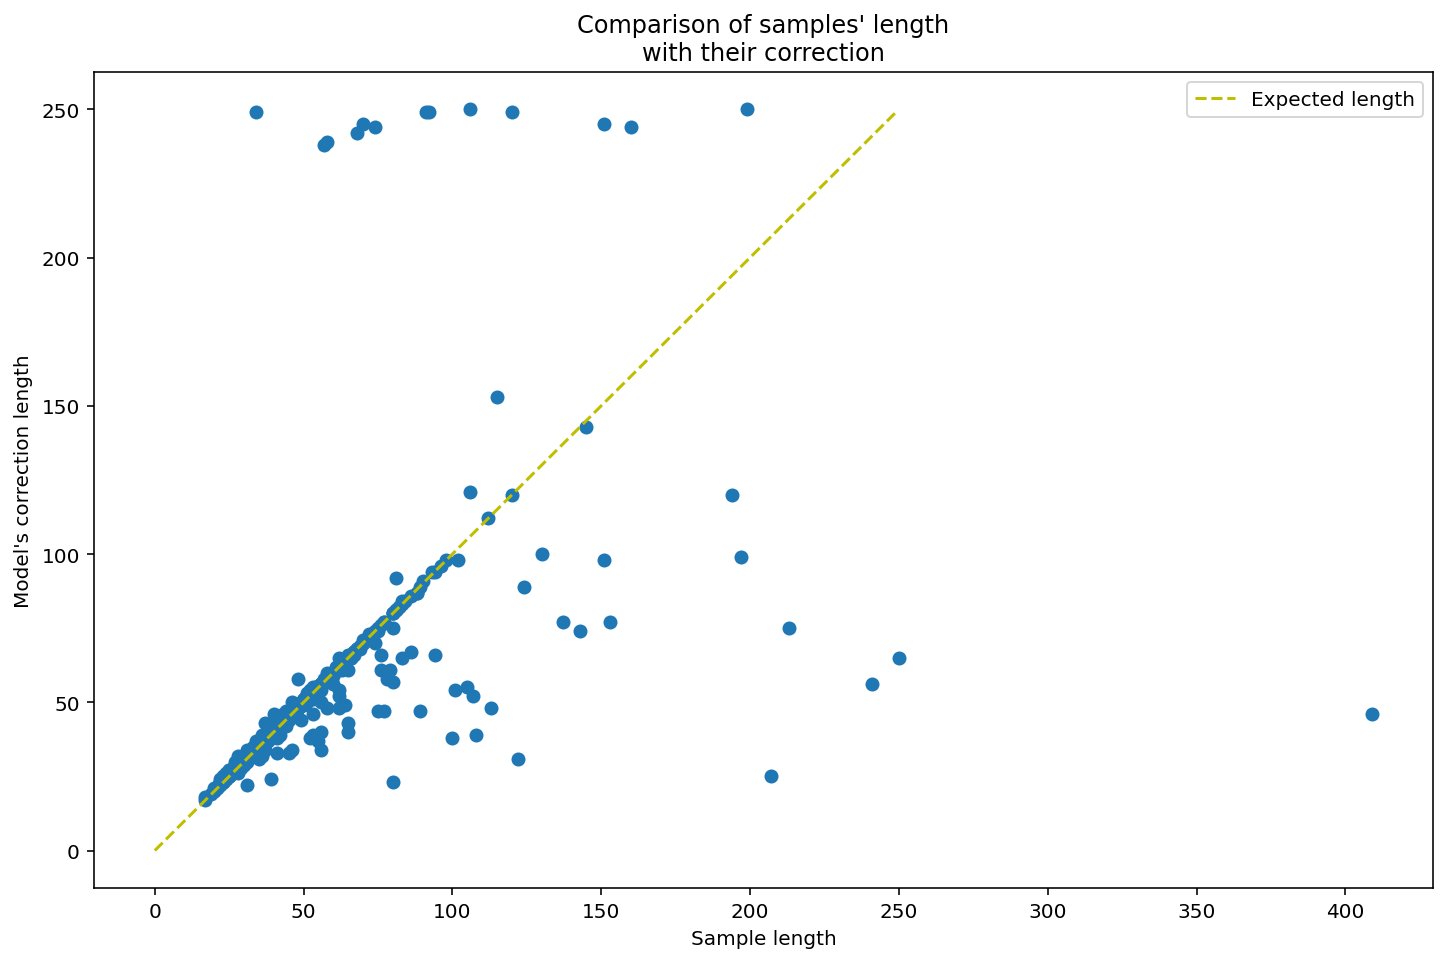

In [ ]:
# Comparison of input length and output length. Are they correlated? Or is the correction model always shortening the output (in a kind of standardization)?
sample_len = test_df["Sample"].apply(len)
pred_len = naive_pred_df["Pred"].apply(len)

%config InlineBackend.figure_format='retina'

plt.figure(figsize=(12, 7.5))
plt.scatter(sample_len, pred_len)
plt.plot(np.arange(250), np.arange(250), "y--", label="Expected length")
plt.legend()
plt.xlabel("Sample length")
plt.ylabel("Model's correction length")
plt.title("Comparison of samples' length\nwith their correction");

They do seem highly correlated (thankfully). But there are still a significant number of samples that are abnormally too short.

Let's try to correct this

### Length post-processing v2 !

In [ ]:
%%script false --no-raise-error

def detection_correction_pipeline(df: pd.DataFrame) -> pd.DataFrame:
    # Detection
    encoding_list = [detection_tokenizer(sample, padding=True, return_tensors="pt") for sample in df["Sample"]]
    errored_samples_pred = np.array([
        detection_model(**encoding).logits.item() > 0.5
        for encoding in encoding_list
    ])

    # Correction
    save_df_on_disk(df.loc[errored_samples_pred, ["Sample"]], ONMT_TEST_SOURCE)
    test()
    errored_pred_df = load_from_disk(ONMT_TEST_PRED, df.loc[errored_samples_pred, "Ground Truth"])

    # Merge error-free samples and corrected ones
    pred_df = pd.concat([
        errored_pred_df,
        df.loc[~errored_samples_pred, ["Sample"]].rename(columns={"Sample": "Pred"}),
    ]).sort_index()
    
    # Post-processing
    return post_process_length(pred_df, df)

post_processed_detector_naive_train_pred_df = detection_correction_pipeline(train_df)
post_processed_detector_naive_train_pred_df

In [ ]:
def post_process_length_v2(
    pred_df: pd.DataFrame,
    input_df: pd.DataFrame,
    *,
    high_cut_threshold: float = 1.70,
    low_cut_threshold: float = 0.90,
) -> pd.DataFrame:
    ratios = np.array(
        [
            len(pred_df.loc[i, "Pred"]) / len(input_df.loc[i, "Sample"])
            for i in range(len(pred_df))
        ]
    )
    mask = (ratios > high_cut_threshold) | (ratios < low_cut_threshold)

    processed_df = pred_df.copy()
    processed_df.loc[mask, "Pred"] = input_df.loc[mask, "Sample"]

    return processed_df

In [ ]:
%%script false --no-raise-error

# Plot to find optimal cut threshold
cter_list = []
cter = load("character")

cut_range = np.linspace(0, 1, 20)
for cut_threshold in tqdm(cut_range):
    processed_df = post_process_length_v2(post_processed_detector_naive_train_pred_df, train_df, low_cut_threshold=cut_threshold)

    cter_list.append(cter.compute(
        predictions=processed_df["Pred"],
        references=train_df["Ground Truth"]
    )["cer_score"])

plt.plot(cut_range, cter_list, label="CER (macro)")
plt.legend()
plt.title("Evolution of CER for different length cut")

cut_range[np.argmin(cter_list)]

In [ ]:
post_processed_v2_naive_pred_df = post_process_length_v2(naive_pred_df, test_df)

post_processed_v2_naive_metrics_df = compute_all_metrics(
    post_processed_v2_naive_pred_df, test_df
)
_, res_df = save_to_all_methods(
    post_processed_v2_naive_metrics_df,
    naive_all_method_dict,
    "Naive + post-processed v2",
)
res_df

Baseline                             Naive                        \
         CER (micro) CER (macro)       WER CER (micro) CER (macro)       WER   
Global      0.037602    0.041686  0.189577    0.143068    0.079904  0.291164   
PER         0.028410    0.025330  0.141672    0.029575    0.021729  0.113582   
ACT         0.025241    0.015491  0.129234    0.152468    0.033095  0.222160   
LOC         0.034666    0.024216  0.173568    0.078638    0.059759  0.176845   
CARDINAL    0.072345    0.076861  0.095870    0.069902    0.066210  0.088475   

         Naive + post-processed v2                        
                       CER (micro) CER (macro)       WER  
Global                    0.039838    0.037234  0.185127  
PER                       0.017272    0.017719  0.102462  
ACT                       0.041913    0.014861  0.119798  
LOC                       0.028214    0.024216  0.124682  
CARDINAL                  0.042750    0.043095  0.062864

In [ ]:
post_processed_v2_detector_naive_pred_df = post_process_length_v2(
    detector_naive_pred_df, test_df
)

post_processed_v2_detector_naive_metrics_df = compute_all_metrics(
    post_processed_v2_detector_naive_pred_df, test_df
)

post_processed_v2_detector_naive_all_method_dict, res_df = save_to_all_methods(
    post_processed_v2_detector_naive_metrics_df,
    post_processed_detector_naive_all_method_dict,
    "Detector & Naive & len post-processed v2",
)
res_df

Baseline                             Naive                        \
         CER (micro) CER (macro)       WER CER (micro) CER (macro)       WER   
Global      0.037602    0.041686  0.189577    0.143068    0.079904  0.291164   
PER         0.028410    0.025330  0.141672    0.029575    0.021729  0.113582   
ACT         0.025241    0.015491  0.129234    0.152468    0.033095  0.222160   
LOC         0.034666    0.024216  0.173568    0.078638    0.059759  0.176845   
CARDINAL    0.072345    0.076861  0.095870    0.069902    0.066210  0.088475   

         Naive & len post-process                       Detector & Naive  \
                      CER (micro) CER (macro)       WER      CER (micro)   
Global                   0.100553    0.071725  0.245144         0.078693   
PER                      0.029575    0.021729  0.113582         0.032060   
ACT                      0.146104    0.032174  0.214286         0.080371   
LOC                      0.064660    0.057235  0.160305         0.046394   
CARDINAL                 0.067013    0.063234  0.086147         0.059503   

                               Detector & Naive & len post-processed  \
         CER (macro)       WER                           CER (micro)   
Global      0.056785  0.226422                              0.070269   
PER         0.022598  0.128674                              0.032060   
ACT         0.021152  0.145107                              0.077098   
LOC         0.042588  0.147583                              0.043393   
CARDINAL    0.058146  0.077998                              0.058925   

                               Detector & Naive & len post-processed v2  \
         CER (macro)       WER                              CER (micro)   
Global      0.055181  0.219598                                 0.035147   
PER         0.022598  0.128674                                 0.020230   
ACT         0.020676  0.140607                                 0.025275   
LOC         0.041664  0.143766                                 0.024012   
CARDINAL    0.057551  0.077998                                 0.043328   

                                
         CER (macro)       WER  
Global      0.037371  0.184077  
PER         0.019741  0.117554  
ACT         0.014116  0.092238  
LOC         0.023916  0.122774  
CARDINAL    0.044456  0.062864

Great results !!!!
From 0.042 macro CER on global Baselin to 0.033 for the latest correction (21% relative improvement).

##### New correction model's edit
They do look like the one in "OCR's raw error (before correction)
There is very little hallucination

In [ ]:
compute_accurary_summary(
    test_df["Sample"], post_processed_v2_detector_naive_pred_df["Pred"]
)  # How OCR's errors are corrected by the correction model ?

UNLV-ISRI OCR Accuracy Report Version 5.1
-----------------------------------------
   40471   Characters
     482   Errors
   98.81%  Accuracy

       0   Reject Characters
       0   Suspect Markers
       0   False Marks
    0.00%  Characters Marked
   98.81%  Accuracy After Correction

     Ins    Subst      Del   Errors
       0        0        0        0   Marked
      55      197      230      482   Unmarked
      55      197      230      482   Total

   Count   Missed   %Right
    5194       62    98.81   ASCII Spacing Characters
    5429       54    99.01   ASCII Special Symbols
    1765       23    98.70   ASCII Digits
    3252       30    99.08   ASCII Uppercase Letters
   24259       69    99.72   ASCII Lowercase Letters
       9        0   100.00   Latin1 Special Symbols
       1        0   100.00   Latin1 Uppercase Letters
     485        4    99.18   Latin1 Lowercase Letters
       8        2    75.00   Latin Extended-A
       2        0   100.00   Cyrillic
      59    

##### Correction examples

In [ ]:
error_analysis = test_df.copy()
error_analysis["Pred"] = post_processed_v2_detector_naive_pred_df["Pred"]


def compute_error_analysis(
    sample_df: pd.Series,
    pred_df: pd.Series,
    gt_df: pd.Series,
    *,
    ascending: bool = True,
) -> pd.DataFrame:
    error_analysis = pd.DataFrame()
    error_analysis["Sample"] = sample_df
    error_analysis["Pred"] = pred_df
    error_analysis["Ground Truth"] = gt_df

    error_analysis["Corrections done"] = error_analysis.apply(
        lambda line: get_diff(line["Sample"], line["Pred"]), axis=1
    )
    error_analysis["CER"] = error_analysis.apply(
        lambda line: f'{cer.compute(predictions=[line["Pred"]], references=[line["Ground Truth"]]):.3f}',
        axis=1,
    )
    error_analysis["Nb edits"] = error_analysis["Corrections done"].apply(len)
    error_analysis["Remaining errors"] = error_analysis.apply(
        lambda line: get_diff(line["Pred"], line["Ground Truth"]), axis=1
    )

    return error_analysis.sort_values(by=["CER", "Nb edits"], ascending=ascending).drop(
        columns="Nb edits"
    )


error_analysis = compute_error_analysis(
    test_df["Sample"],
    post_processed_v2_detector_naive_pred_df["Pred"],
    test_df["Ground Truth"],
)

pd.set_option("display.max_rows", 840)
error_analysis

Sample  \
1                                                                                                                                                                                                                                                                                                                                                                     PERRIER, r. de la Grande-Truanderie , 50.\nFab. objets de fantaisie.   
3                                                                                                                                                                                                                                                                                                                                                                               Leperrier, entrepreneur de maçonnerie, boul.\nd'Enfer, 20.   
5                                                                                                                                                                                                                                                                                                                                                                                             Vigneron, peintre lithog., Rochechouart, 38.   
6                                                                                                                                                                                                                                                                                                                                                                                                        Bonvallet, Bourbon-Villeneuve, 9.   
10                                                                                                                                                                                                                                                                                                                                                                                                          Froger, N.-D.-de-Nazareth, 20.   
12                                                                                                                                                                                                                                                                                                                                                             Catelle (Alphonse), quincaill. commiss., Ste-Croix-de-\nla-Bretonnerie, 23.   
13                                                                                                                                                                                                                                                                                                                                                                                       Georget (miniat. gouaches ) rue Feydeau, no. 223.   
16                                                                                                                                                                                                                                                                                                                                                                                                               Levasseur, Roquette, 179.   
18                                                                                                                                                                                                                                                                                                                                                                                                            Ballin, Basse-d'Orléans, 14.   
19                                                                                                                      

In [ ]:
error_analysis.apply(
    lambda line: line["CER"] == "0.000", axis=1
).mean(), error_analysis.apply(
    lambda line: cer.compute(
        predictions=[line["Sample"]], references=[line["Ground Truth"]]
    )
    == 0,
    axis=1,
).mean()  # By how much did we increased the number of error free lines ? 10% relative improvement

(0.4452380952380952, 0.4583333333333333)

##### Other

In [ ]:
# Weirdly correct a number ?
extract_sample_with("Temple, 2")

### Global API (in sklearn style)
[TO BE REMOVED]

In [7]:
from tempfile import TemporaryDirectory


class SupervisedCharNMT:
    """ """

    def __init__(
        self,
        config: Path,
        nmt_model: Path,
        *,
        detector_model_name: str = "camembert-base",
        use_detector: bool = True,
        use_length_post_processing: bool = True,
    ):
        self.detector_tokenizer = CamembertTokenizer.from_pretrained(
            detector_model_name
        )
        self.detector_model = CamembertForSequenceClassification.from_pretrained(
            detector_model_name, num_labels=1
        )

    def fit(self):  # , X_: pd.DataFrame, y: pd.DataFrame):
        """
        Example usage:
        ```
        # Should be the same as 'data/train/path_src' and
        # 'data/train/path_tgt' in `config` file.
        X_path = Path("data/train.src")
        Y_path = Path("data/train.tgt")


        save_df_on_disk(X, X_path)
        save_df_on_disk(y, Y_path)

        model = SupervisedCharNMT(config_path, model_path)
        model.fit()
        ```
        """
        if use_detector:
            args = TrainingArguments(
                f"{self.detector_model_name}-finetuned",
                evaluation_strategy="epoch",
                save_strategy="epoch",
                load_best_model_at_end=True,
                metric_for_best_model="precision",
                per_device_train_batch_size=32,
                num_train_epochs=10,
            )

            trainer = Trainer(
                self.detector_model,
                args,
                train_dataset=train_dataset,
                eval_dataset=eval_dataset,
                tokenizer=tokenizer,
                compute_metrics=compute_metrics,
            )
            trainer.train()

        train(config, nmt_model, force_training=True)

        # Automatically computes threshold for post-processing ?
        if use_length_post_processing:
            pass

    def predict(self, X: pd.DataFrame):
        # Detector inference
        if use_detector:
            encoding_list = [
                self.detector_tokenizer(sample, padding=True, return_tensors="pt")
                for sample in X["Sample"]
            ]
            errored_samples_pred = [
                self.detector_model(**encoding).logits.item() > 0.5
                for encoding in encoding_list
            ]
            errored_samples_pred = np.array(errored_samples_pred)
        else:
            # Considered all errored otherwise
            errored_samples_pred = np.ones(len(X), dtype=bool)

        # NMT inference
        with TemporaryDirectory() as X_path, TemporaryDirectory() as Y_path:
            save_df_on_disk(X.loc[errored_samples_pred, ["Sample"]], X_path)
            test(nmt_model, X_path, Y_path)
            corrected_y_pred = load_from_disk(
                Y_path, template_df=X.loc[errored_samples_pred, "Sample"]
            )

        # Merge corrected samples and predicted-as-correct ones
        y_pred = pd.concat(
            [
                corrected_y_pred,
                X.loc[~errored_samples_pred, ["Sample"]].rename(
                    columns={"Sample": "Pred"}
                ),
            ]
        ).sort_index()

        # Length post-processing
        if use_length_post_processing:
            y_pred = post_process_length_v2(y_pred, X)

        return y_pred

    def score(self, X: pd.DataFrame, y: pd.DataFrame):
        y_pred = self.predict(X)
        return compute_all_metrics(y_pred, y)